In [3]:
# Clean dataframe to remove NA values and train test split
import pandas as pd

df = pd.read_csv('property_data_with_coordinates.csv')

# Ensure Date column is datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Extract year from Date
df['Year'] = df['Date'].dt.year

# Also filter out 'UNKNOWN' values in categorical features
df_clean = df[
    df['PropertyType'].notna() & 
    (df['PropertyType'] != 'UNKNOWN') &
    df['NewBuildFlag'].notna() & 
    (df['NewBuildFlag'] != 'UNKNOWN') &
    df['Tenure'].notna() &
    (df['Tenure'] != 'UNKNOWN')
].copy()

# Step 2: Split data into training (2022-2023) and prediction (2024)
train_data = df_clean[df_clean['Year'].isin([2022, 2023])].copy()
predict_data = df_clean[df_clean['Year'] == 2024].copy()

print(f"Training data (2022-2023): {len(train_data)} rows")
print(f"2024 data to predict: {len(predict_data)} rows")


Training data (2022-2023): 217343 rows
2024 data to predict: 99380 rows


In [12]:
import pgeocode

# Initialize UK geocoder
nomi = pgeocode.Nominatim('GB')

# Query postcodes (file is encoded in Windows-1252, not UTF-8)
schools = pd.read_csv('edubasealldata20251112.csv', encoding='latin-1')
schools = schools[schools['Town']== "London"]

# Extract outward code (first part before space) - pgeocode only uses outward codes for UK
schools['PostcodeOutward'] = schools['Postcode'].str.split().str[0]

# Get unique outward codes and query them
unique_postcodes = schools['PostcodeOutward'].dropna().unique()
coords = nomi.query_postal_code(unique_postcodes)

# Merge back using outward code
schools = schools.merge(
    coords[['postal_code', 'latitude', 'longitude']],
    left_on='PostcodeOutward',
    right_on='postal_code',
    how='left'
)

print(schools[['Postcode', 'PostcodeOutward', 'latitude', 'longitude']].head())



/var/folders/_6/n4f9pfd14lv1q8nl3892x2v80000gn/T/ipykernel_37767/2849719218.py:7: DtypeWarning: Columns (48,50,51,69,70,93,124,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  schools = pd.read_csv('edubasealldata20251112.csv', encoding='latin-1')


   Postcode PostcodeOutward  latitude  longitude
0  EC3A 5DE            EC3A   51.5154    -0.0828
1  EC2Y 8BB            EC2Y   51.5198    -0.0948
2  EC4M 9AD            EC4M   51.5085    -0.1257
3  EC4V 3AL            EC4V   51.5085    -0.1257
4   NW5 4LP             NW5   51.5517    -0.1413


In [13]:
# Drop schools with no coordinates
print(len(schools))
schools = schools[schools['latitude'].notna() & schools['longitude'].notna()]
print(len(schools))

3297
3292


In [14]:
# Calculate education proximity index for each property (optimized with spatial indexing)
from geopy.distance import geodesic
import numpy as np
from scipy.spatial import cKDTree

# Extract school coordinates
school_coords = schools[['latitude', 'longitude']].dropna().values

# Build spatial index for fast radius queries
print(f"Building spatial index for {len(school_coords)} schools...")
school_tree = cKDTree(school_coords)

# Filter properties with valid coordinates
valid_mask = df_clean['lat'].notna() & df_clean['long'].notna()
property_coords = df_clean.loc[valid_mask, ['lat', 'long']].values

print(f"Calculating education proximity index for {len(property_coords)} properties...")

# Find all schools within 2km radius for each property
radius_deg = 2 / 111.0  # Convert km to approximate degrees
indices_list = school_tree.query_ball_point(property_coords, radius_deg)

# Calculate weighted index for each property
education_indices = np.zeros(len(df_clean))
radius_km = 2

for i, (prop_idx, nearby_indices) in enumerate(zip(valid_mask[valid_mask].index, indices_list)):
    if len(nearby_indices) == 0:
        continue
    
    # Get property coordinates
    prop_lat, prop_lon = property_coords[i]
    
    # Calculate exact geodesic distances and weights
    index = 0
    for school_idx in nearby_indices:
        school_lat, school_lon = school_coords[school_idx]
        distance = geodesic((prop_lat, prop_lon), (school_lat, school_lon)).km
        
        if distance <= radius_km:
            weight = (radius_km - distance) / radius_km
            index += weight
    
    education_indices[prop_idx] = index

df_clean['education_proximity_index'] = education_indices

# Update train_data and predict_data
train_data = df_clean[df_clean['Year'].isin([2022, 2023])].copy()
predict_data = df_clean[df_clean['Year'] == 2024].copy()

print(f"Education proximity index calculated!")
print(f"Mean index: {df_clean['education_proximity_index'].mean():.2f}")
print(f"Max index: {df_clean['education_proximity_index'].max():.2f}")


Building spatial index for 3292 schools...
Calculating education proximity index for 316250 properties...
Education proximity index calculated!
Mean index: 14.23
Max index: 78.33


In [15]:
# Linear Regression Models by Property Type using Education Proximity Index
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import statsmodels.api as sm

print("\n" + "=" * 70)
print("LINEAR REGRESSION MODELS BY PROPERTY TYPE")
print("Using Education Proximity Index (2022-2023) to Predict 2024 Prices")
print("=" * 70)

# First, check what property types exist in the data
print("\n1. Property Types in the Data:")
print("-" * 70)
property_type_counts = train_data['PropertyType'].value_counts().sort_index()
print(property_type_counts)
print(f"\nTotal unique property types: {train_data['PropertyType'].nunique()}")
print(f"Property types: {sorted(train_data['PropertyType'].unique())}")

# Prepare features: education_proximity_index, NewBuildFlag, Tenure
feature_cols_by_type = ['education_proximity_index', 'NewBuildFlag', 'Tenure']

# Dictionary to store models and results for each property type
property_type_models = {}
property_type_results = {}

print("\n2. Training Separate Models for Each Property Type:")
print("=" * 70)

# Train a separate model for each property type
for prop_type in sorted(train_data['PropertyType'].unique()):
    print(f"\n--- Property Type: {prop_type} ---")
    
    # Filter data for this property type
    train_data_type = train_data[train_data['PropertyType'] == prop_type].copy()
    predict_data_type = predict_data[predict_data['PropertyType'] == prop_type].copy()
    
    if len(train_data_type) == 0:
        print(f"  ⚠️  No training data for property type {prop_type}")
        continue
    
    # Filter out rows with missing education_proximity_index or Price
    train_data_type = train_data_type[
        train_data_type['education_proximity_index'].notna() & 
        train_data_type['Price'].notna()
    ].copy()
    
    if len(train_data_type) == 0:
        print(f"  ⚠️  No valid training data (missing education_proximity_index or Price)")
        continue
    
    print(f"  Training samples: {len(train_data_type)}")
    print(f"  Prediction samples: {len(predict_data_type)}")
    
    # Prepare features (without PropertyType)
    X_train_type_raw = train_data_type[feature_cols_by_type].copy()
    y_train_type = train_data_type['Price'].values
    
    # Create preprocessor for this property type (categories may differ)
    preprocessor_type = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', [0]),  # education_proximity_index (numerical)
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), [1, 2])  # NewBuildFlag, Tenure
        ],
        remainder='drop'
    )
    
    # Fit and transform
    X_train_type = preprocessor_type.fit_transform(X_train_type_raw)
    
    # Train model with sklearn (for predictions)
    model_type = LinearRegression()
    model_type.fit(X_train_type, y_train_type)
    
    # Train model with statsmodels (for p-values)
    X_train_type_sm = sm.add_constant(X_train_type)  # Add intercept term
    model_sm = sm.OLS(y_train_type, X_train_type_sm).fit()
    
    # Get p-value for education proximity coefficient (first coefficient after intercept)
    education_prox_pvalue = model_sm.pvalues[1]  # Index 0 is intercept, 1 is first feature
    
    # Evaluate on training data
    y_train_pred_type = model_type.predict(X_train_type)
    train_r2_type = r2_score(y_train_type, y_train_pred_type)
    train_rmse_type = np.sqrt(mean_squared_error(y_train_type, y_train_pred_type))
    
    print(f"  Training R²: {train_r2_type:.4f}")
    print(f"  Training RMSE: £{train_rmse_type:,.2f}")
    print(f"  Intercept: £{model_type.intercept_:,.2f}")
    print(f"  Education Proximity coefficient: £{model_type.coef_[0]:,.2f} per index unit")
    print(f"  Education Proximity p-value: {education_prox_pvalue:.6f} {'***' if education_prox_pvalue < 0.001 else '**' if education_prox_pvalue < 0.01 else '*' if education_prox_pvalue < 0.05 else ''}")
    
    # Make predictions for 2024 data
    test_r2_type = None
    test_rmse_type = None
    if len(predict_data_type) > 0:
        # Filter out rows with missing education_proximity_index
        predict_data_type_valid = predict_data_type[
            predict_data_type['education_proximity_index'].notna()
        ].copy()
        
        if len(predict_data_type_valid) > 0:
            X_predict_type_raw = predict_data_type_valid[feature_cols_by_type].copy()
            X_predict_type = preprocessor_type.transform(X_predict_type_raw)
            y_predict_type = model_type.predict(X_predict_type)
            
            # Store predictions
            predict_data_type_valid = predict_data_type_valid.copy()
            predict_data_type_valid['Predicted_Price'] = y_predict_type
            
            # Evaluate on test data if actual prices exist
            if predict_data_type_valid['Price'].notna().any():
                actual_prices_type = predict_data_type_valid['Price'].dropna()
                predicted_prices_type = predict_data_type_valid.loc[actual_prices_type.index, 'Predicted_Price']
                test_r2_type = r2_score(actual_prices_type, predicted_prices_type)
                test_rmse_type = np.sqrt(mean_squared_error(actual_prices_type, predicted_prices_type))
                print(f"  Test R²: {test_r2_type:.4f}")
                print(f"  Test RMSE: £{test_rmse_type:,.2f}")
            
            # Update predict_data_type to include predictions
            predict_data_type = predict_data_type_valid
    
    # Store model and results
    property_type_models[prop_type] = {
        'model': model_type,
        'preprocessor': preprocessor_type,
        'train_data': train_data_type,
        'predict_data': predict_data_type
    }
    
    property_type_results[prop_type] = {
        'train_r2': train_r2_type,
        'train_rmse': train_rmse_type,
        'test_r2': test_r2_type,
        'test_rmse': test_rmse_type,
        'n_train': len(train_data_type),
        'n_predict': len(predict_data_type),
        'intercept': model_type.intercept_,
        'education_proximity_coef': model_type.coef_[0],
        'education_proximity_pvalue': education_prox_pvalue
    }

# Summary comparison
print("\n3. Model Comparison Summary:")
print("=" * 70)
print(f"{'Property Type':<15} {'Train R²':<12} {'Train RMSE':<18} {'Test R²':<12} {'Test RMSE':<18} {'Train N':<10} {'Education Prox Coef':<22} {'P-value':<12}")
print("-" * 70)

for prop_type in sorted(property_type_results.keys()):
    results = property_type_results[prop_type]
    test_r2_str = f"{results['test_r2']:.4f}" if results['test_r2'] is not None else "N/A"
    test_rmse_str = f"£{results['test_rmse']:,.2f}" if results['test_rmse'] is not None else "N/A"
    pval_str = f"{results['education_proximity_pvalue']:.6f}"
    sig_str = '***' if results['education_proximity_pvalue'] < 0.001 else '**' if results['education_proximity_pvalue'] < 0.01 else '*' if results['education_proximity_pvalue'] < 0.05 else ''
    
    print(f"{prop_type:<15} {results['train_r2']:>11.4f} £{results['train_rmse']:>16,.2f} {test_r2_str:>11} {test_rmse_str:>17} {results['n_train']:>9} £{results['education_proximity_coef']:>20,.2f} {pval_str:>11} {sig_str}")

# Calculate weighted average performance
total_train_n = sum(r['n_train'] for r in property_type_results.values())
weighted_train_r2 = sum(r['train_r2'] * r['n_train'] for r in property_type_results.values()) / total_train_n
weighted_train_rmse = np.sqrt(sum(r['train_rmse']**2 * r['n_train'] for r in property_type_results.values()) / total_train_n)

print(f"\n4. Overall Performance:")
print("-" * 70)
print(f"Weighted Average (All Property Types) - Train R²: {weighted_train_r2:.4f}, Train RMSE: £{weighted_train_rmse:,.2f}")

print("\n5. Key Insights:")
print("-" * 70)
print("✓ Separate models allow each property type to have its own:")
print("  - Education proximity coefficient (how price changes with education amenities)")
print("  - Intercept (base price)")
print("  - Relationship with NewBuildFlag and Tenure")
print("\n✓ This approach captures property-type-specific patterns")
print("  in how education proximity affects property prices.")
print("\n✓ P-value significance levels:")
print("  - *** p < 0.001 (highly significant)")
print("  - **  p < 0.01  (very significant)")
print("  - *   p < 0.05  (significant)")
print("  -     p >= 0.05 (not significant)")

print("=" * 70)



LINEAR REGRESSION MODELS BY PROPERTY TYPE
Using Education Proximity Index (2022-2023) to Predict 2024 Prices

1. Property Types in the Data:
----------------------------------------------------------------------
PropertyType
D      9131
F    116047
O     11967
S     27466
T     52732
Name: count, dtype: int64

Total unique property types: 5
Property types: ['D', 'F', 'O', 'S', 'T']

2. Training Separate Models for Each Property Type:

--- Property Type: D ---
  Training samples: 9131
  Prediction samples: 4278
  Training R²: 0.0920
  Training RMSE: £1,967,007.53
  Intercept: £1,121,253.19
  Education Proximity coefficient: £69,791.65 per index unit
  Education Proximity p-value: 0.000000 ***
  Test R²: 0.1012
  Test RMSE: £1,790,122.44

--- Property Type: F ---
  Training samples: 116047
  Prediction samples: 50177
  Training R²: 0.0237
  Training RMSE: £964,186.50
  Intercept: £784,772.69
  Education Proximity coefficient: £6,806.37 per index unit
  Education Proximity p-value: 0.000

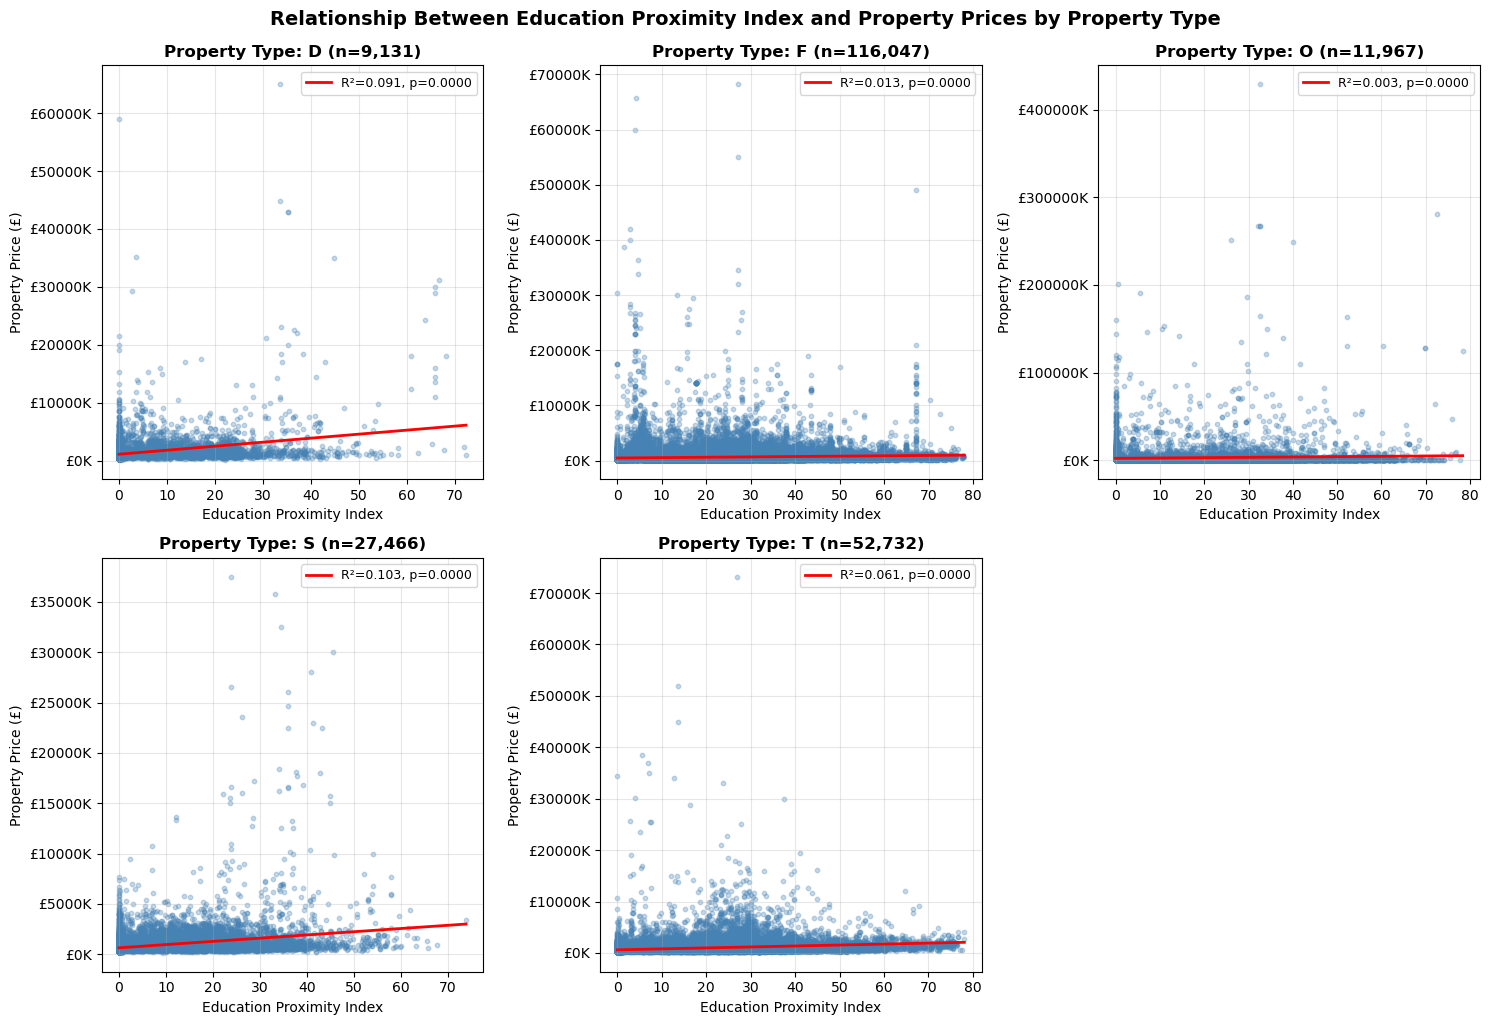


Plotted 5 property types: D, F, O, S, T


In [16]:
# Plot relationship between education proximity index and property prices by property type
import matplotlib.pyplot as plt
from scipy import stats

# Get unique property types
property_types = sorted(train_data['PropertyType'].unique())

# Create subplots
n_types = len(property_types)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_types > 1 else [axes]

for idx, prop_type in enumerate(property_types):
    ax = axes[idx]
    
    # Filter data for this property type
    data_type = train_data[
        (train_data['PropertyType'] == prop_type) &
        (train_data['education_proximity_index'].notna()) &
        (train_data['Price'].notna())
    ].copy()
    
    if len(data_type) == 0:
        ax.text(0.5, 0.5, f'No data for {prop_type}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Property Type: {prop_type}')
        continue
    
    # Create scatter plot
    ax.scatter(data_type['education_proximity_index'], data_type['Price'], 
               alpha=0.3, s=10, color='steelblue')
    
    # Fit linear regression for trend line
    x = data_type['education_proximity_index'].values
    y = data_type['Price'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Plot regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r-', linewidth=2, 
            label=f'R²={r_value**2:.3f}, p={p_value:.4f}')
    
    # Formatting
    ax.set_xlabel('Education Proximity Index', fontsize=10)
    ax.set_ylabel('Property Price (£)', fontsize=10)
    ax.set_title(f'Property Type: {prop_type} (n={len(data_type):,})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Format y-axis to show prices in thousands
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000:.0f}K'))

# Hide unused subplots
for idx in range(n_types, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Relationship Between Education Proximity Index and Property Prices by Property Type', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print(f"\nPlotted {n_types} property types: {', '.join(property_types)}")
